# Peer-graded Assignment: Подготовка данных для построения модели
## Разбиение данных
Начнем с простого, но важного шага. Отделите небольшую выборку от существующих данных. Назовем её hold-out dataset. Эта выборка нужна для контроля качества решения: она не должна использоваться вплоть до контроля качества решения. Наличие такой выборки поможет убедиться, что в процессе моделирования не было допущено ошибок, не произошло переобучение. В качестве ответа загрузите полученный файл (или файлы, если вы работаете а данными и метками как с 2мя файлами)

In [1]:
import pandas as pd
import random
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt

Сгенерируем и зафиксируем случайное число, которое в дальнейшем будем использовать как seed

In [2]:
# seed = random.randint(0, 10000)
seed = 1903
seed

1903

Загрузим выборку

In [3]:
churn_data_frame = pd.read_csv("..\..\Data\orange_small_churn_data.train", ",")
labels_frame = pd.read_csv("..\..\Data\orange_small_churn_labels.train", header=None)

print(churn_data_frame.shape)
print(labels_frame.shape)

(40000, 230)
(40000, 1)


Разделим фрейм на два. В одном фрейме будут лежать данные класса "отток", а в другом класса "не отток"

In [4]:
churn_indices = list(labels_frame[labels_frame[0] == 1].index)
not_churn_indices = list(labels_frame[labels_frame[0] == -1].index)

churn_frame = churn_data_frame.loc[churn_indices, :]
not_churn_frame = churn_data_frame.loc[not_churn_indices, :]

churn_labels = labels_frame.loc[churn_indices, :]
not_churn_labels = labels_frame.loc[not_churn_indices, :]

print (churn_frame.shape, not_churn_frame.shape, churn_labels.shape, not_churn_labels.shape)

(2976, 230) (37024, 230) (2976, 1) (37024, 1)


Теперь возьмем по 30% из выборки класса "отток" и 30% из выборки класса "не отток", чтобы сохранить соотношение классов в тренировочной и тестовой выборках

In [5]:
test_proportion = 0.3
(churn_train_data,
 churn_test_data,
 churn_train_labels,
 churn_test_labels) = train_test_split(
    churn_frame,
    churn_labels,
    test_size=test_proportion,
    random_state=seed)

(not_churn_train_data,
 not_churn_test_data,
 not_churn_train_labels,
 not_churn_test_labels) = train_test_split(
    not_churn_frame,
    not_churn_labels,
    test_size=test_proportion,
    random_state=seed)

# Проверим, что количество данных осталось тем же
print (churn_train_data.shape,
       churn_test_data.shape,
       churn_train_data.shape[0] + churn_test_data.shape[0],
       churn_train_labels.shape,
       churn_test_labels.shape,
       churn_train_labels.shape[0] + churn_test_labels.shape[0])
print (not_churn_train_data.shape,
       not_churn_test_data.shape,
       not_churn_train_data.shape[0] + not_churn_test_data.shape[0],
       not_churn_train_labels.shape,
       not_churn_test_labels.shape,
       not_churn_train_labels.shape[0] + not_churn_test_labels.shape[0])

(2083, 230) (893, 230) 2976 (2083, 1) (893, 1) 2976
(25916, 230) (11108, 230) 37024 (25916, 1) (11108, 1) 37024


Теперь объединим данные в два датасета train и test

In [6]:
def concatenate_classes(churn_data, not_churn_data, churn_labels, not_churn_labels):
    train_data = pd.concat([churn_data, not_churn_data], axis = 0, ignore_index=True)
    train_labels = pd.concat([churn_labels, not_churn_labels], axis = 0, ignore_index=True)
    train_data["labels"] = train_labels.as_matrix()
    return train_data

In [7]:
train_data = concatenate_classes(
    churn_train_data,
    not_churn_train_data,
    churn_train_labels,
    not_churn_train_labels)

test_data = concatenate_classes(
    churn_test_data,
    not_churn_test_data,
    churn_test_labels,
    not_churn_test_labels)

# Проверим, что размерность данных сохранена
print (train_data.shape,
       test_data.shape,
       (train_data.shape[0] + test_data.shape[0], train_data.shape[1], test_data.shape[1]),
       churn_data_frame.shape)

(27999, 231) (12001, 231) (40000, 231, 231) (40000, 230)


Перемешаем наборы данных, чтобы классы не были разделены заранее внутри датасетов

In [8]:
train_data = pd.DataFrame(shuffle(train_data.as_matrix(), random_state=seed), columns = train_data.columns)
test_data = pd.DataFrame(shuffle(test_data.as_matrix(), random_state=seed), columns = test_data.columns)

In [9]:
train_result_labels = pd.DataFrame(train_data["labels"])
train_result_data = train_data.drop("labels", axis=1)

test_result_labels = pd.DataFrame(test_data["labels"])
test_result_data = test_data.drop("labels", axis=1)

# Проверим, что размерность данных сохранена
print (train_result_data.shape,
       test_result_data.shape,
       train_result_labels.shape,
       test_result_labels.shape,
       (train_data.shape[0] + test_data.shape[0], train_data.shape[1], test_data.shape[1]),
       churn_data_frame.shape)

(27999, 230) (12001, 230) (27999, 1) (12001, 1) (40000, 231, 231) (40000, 230)


Проверим, что пропорции в данных сохранились до и после разделения

In [10]:
def show_proportion_data(frame, column, label):
    proportion_plot = frame.plot(
        kind="hist",
        title="Labels proportion",
        figsize=(2,3),
        legend=False)
    proportion_plot.set_xlabel("Label value")
    proportion_plot.set_ylabel("Label frequency")
    not_churn_proportion = float(frame[frame[column] == -1].shape[0])/float(frame.shape[0])
    churn_proportion = float(frame[frame[column] == 1].shape[0])/float(frame.shape[0])
    print ("Доля ответов класса \"отток\": %.4f%%\nДоля ответов класса \"не отток\": %.4f%%\nКласса \"отток\" меньше в %.4f раз" % (churn_proportion, not_churn_proportion, not_churn_proportion/churn_proportion))
    plt.show()

Доля ответов класса "отток": 0.0744%
Доля ответов класса "не отток": 0.9256%
Класса "отток" меньше в 12.4409 раз


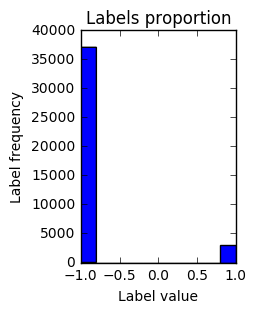

Доля ответов класса "отток": 0.0744%
Доля ответов класса "не отток": 0.9256%
Класса "отток" меньше в 12.4417 раз


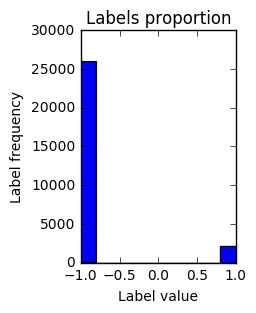

Доля ответов класса "отток": 0.0744%
Доля ответов класса "не отток": 0.9256%
Класса "отток" меньше в 12.4390 раз


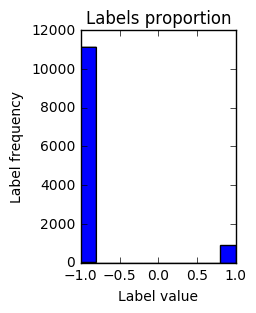

In [11]:
show_proportion_data(labels_frame, 0, "Proportion before splitting")
show_proportion_data(train_result_labels, "labels", "Proportion train")
show_proportion_data(test_result_labels, "labels", "Proportion test")

In [12]:
train_result_data.to_csv("..\..\Data\churn_data_train.csv", index=False)
train_result_labels.to_csv("..\..\Data\churn_labels_train.csv", index=False)
test_result_data.to_csv("..\..\Data\churn_data_holdout.csv", index=False)
test_result_labels.to_csv("..\..\Data\churn_labels_holdout.csv", index=False)

# Объединить отложенную выборку в один датасет для загрузки на Coursera
test_result_data["labels"] = test_result_labels.as_matrix().flatten()
test_result_data.to_csv("..\..\Data\churn_data_full_holdout.csv", index=False)

# Подумать о пропусках, стоит ли их учитывать во время разбиения

## Обработка категориальных признаков
Подумайте и предложите несколько способов (не менее 3х) обработки категориальных признаков, для того, чтобы их можно было использовать при построении модели. Обратите внимание на модуль sklearn.preprocessing. Начать поиски можно с sklearn.preprocessing.OneHotEncoder.

- **pandas.Series.nunique** - позволяет найти количество уникальных значений в колонке
- **sklearn.preprocessing.LabelEncoder** - Кодирует значения признаков числами от 0 до n, где n - количество классов.
- **sklearn.preprocessing.OneHotEncoder** - На вход подаётся целочисленна матрица, где каждая колонка представляет собой категориальный признак. На выходе получаем разреженную матрицу бинарных признаков, где каждый бинарный признак соответствует одному категориальному значению.<br/>Хорошо подходит для линейных моделей и SVM.
- **sklearn.preprocessing.LabelBinarizer** - Преобразует категориальный признак в бинарный по стратегии One-vs-all. Т.е. на выходе получается один бинарный признак.<br/>Нужен для преобразования вектора ответов при мультиклассовой классификации.

Есть множество способов работы с категориальными признаками, и нет ни одного универсального способа, который позволил бы один раз закодировать признаки и быть уверенным, что они будут идеально работать в любой модели. Рассмотрим некоторые способы:
1. Кодирование признаков целочисленными значениями. Доступен из функции **sklearn.preprocessing.LabelEncoder**. Такой подход однозначно не является лучшим. Линейные модели при таком подходе начинают учитывать не имеющую смысла упорядоченность значений признаков. Также модели, основанные на признаках закодированных таким способом, неустойчивы к перестановке значений признаков. Однако нам понадобится такое кодирование, чтобы преобразовать строковые категории к численным, т.к. большинство методов кодирования (тот-же OneHotEncoder) работает именно с матрицами чисел.
2. One hot или Dummy кодирование. Доступен из функции **sklearn.preprocessing.OneHotEncoder**. Преобразует матрицу категориальных значений в разреженную матрицу бинарных значений. В этой матрице каждый признак соответствует одному значению в каком-то категориальном признаке. Такой подход также имеет минусы, наиболее важным из них является сильно увеличивающаяся размерность пространства.
3. Бинарное кодирование: преобразовать каждую категорию в десятичное, а затем двоичное число. После этого каждый разряд двоичного числа сделать отдельным признаком. Этот сокращает размерность признакового пространства по сравнению с OneHotEncoder.
4. Некоторые признаки можно закодировать через другие. Например категорию товара можно закодировать средней ценой товара. Тут есть пара проблем. Во-первых средняя цена разных категорий может совпасть. Во-вторых в нашем наборе данных имена колонок не имеют смысла, что очень сильно усложняет нахождение связей между признаками.
5. Можно каждую категорию закодировать числом входящих в нее объектов. Опять же иногда это может привести к слиянию категорий.
6. Всегда остаётся возможность использовать модели, позволяющие использовать категориальные признаки в необработанном виде. Например, любые алгоритмы на основе решающих деревьев.

Есть также некоторые вспомогательные методы работы с категориальными признаками.
Например, для уменьшения признакового пространства можно использовать группировку признаков. Берется два или более признака, затем из их значений создается один новый котегориальный признак, объединяющий значения исходных. Помочь в таком преобразовании может функция **pandas.crosstab**. Тут важно, чтобы итоговое количество категорий уменьшилось. Недостатком является то, что при появлении новых значений в тестовой выборке их будет тяжело добавить.

**pandas.Series.nunique** - позволяет найти количество уникальных значений в колонке

[Categorial Kaggle](https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf)
Погуглить Imputer, Polynomial features, “улыбка волатильности”

## Выбор метрики качества
Подумайте, с помощью какой метрики качества лучше всего оценивать качество будущей модели, какой будет ключевая метрика качества? Поясните свой выбор.

В данной задаче нельзя использовать долю правильных ответов. Данные имеют сильный скос в сторону класса "не отток", а эта метрика очень плохо работает для перекошенных данных.

На мой взгляд здесь стоит пользоваться метриками Precision и Recall. В общем-то задача поиска клиентов, желающих уйти чем-то напоминает диагностику заболевания. Надо выловить как можно больше уходящих клиентов и минимизировать количество скидок, розданных клиентам, которые всем довольны.
В таком случае имеет смысл задать порог (зафиксировать) для значения Recall и максимизировать Precision.
Поскольку бизнес-требований нет, и порог не определен, то просто возьмем объединенную Precision-Recall метрику. Я выбрал F-меру.
$$\frac{2*precision*recall}{precision + recall}$$

Какие вспомогательные метрики качества имеет смысл считать, чтобы более полно оценить качество модели, понять, где её слабые стороны и что нужно улучшать?

Как вспомогательную метрику для измерения качества оценок принадлежности к классу можно использовать метрику AUR-ROC, т.к. она не чувствительна к балансу классов.

### Lift
На практике часто возникают задачи, связанные с выбором подмножества: выделение лояльных клиентов банка, выделение уходящих пользователей мобильного оператора и т.д. Заказчика может интересовать вопрос, насколько выгоднее работать с этим подмножеством по сравнению со всем множеством. Если при рассылке предложений о кредите клиентам из подмножества и всем клиентам будет получаться одна и та же доля откликнувшихся, то подмножество не будет представлять особой ценности. Формально это измеряется с помощью прироста концентрации (lift), который равен отношению точности к доле положительных объектов в выборке:
$$\frac{precision}{(TP + FN)/l}$$
Эту величину можно интерпретировать как улучшение доли положительных объектов в данном подмножестве относительно доли в случайно выбранном подмножестве такого же размера.

## Выбор стратегии кросс-валидации
Подберите оптимальную стратегию проведения кросс-валидации: решите, на сколько фолдов вы будете делить выборку? Выберите тип разбиения данных (k-fold, stratified k-fold, shuffle split, leave one out). Поясните ваш выбор.

Отбросим k-fold и shuffle split, т.к. они не гарантируют сохранение соотношения между классами после разбиения выборки.
Leave one out на мой взгляд тоже не подходит, т.к. надо строить модель n-1 раз, а у нас даже после того, как мы сделали hold-out выборку осталось 27999 объектов.
Остается stratified k-fold

посмотреть RepeatedStratifiedKFold
решить на сколько фолдов разбивать. Почитать что-то кроме [machinelearning.ru](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D1%80%D0%BE%D1%81%D1%81-%D0%B2%D0%B0%D0%BB%D0%B8%D0%B4%D0%B0%D1%86%D0%B8%D1%8F)